In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import statsmodels.api as sm

In [2]:
df = pd.read_csv('Data/train.csv')
test_data = pd.read_csv('Data/test.csv')

titanic = df.copy()

In [3]:
titanic.isnull().sum()

passengerId      0
survived         0
pclass           0
name             0
sex              0
age            177
sibsp            0
parch            0
ticket           0
fare             0
cabin          687
embarked         2
dtype: int64

In [4]:
test_data.isnull().sum()

passengerId      0
pclass           0
name             0
sex              0
age             86
sibsp            0
parch            0
ticket           0
fare             1
cabin          327
embarked         0
dtype: int64

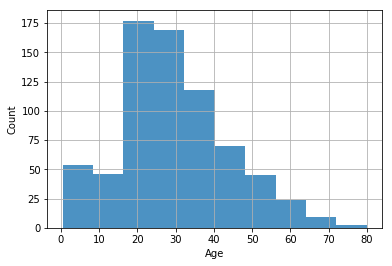

In [6]:
ax = titanic["age"].hist(alpha=0.8)
ax.set(xlabel='Age', ylabel='Count')
plt.show()

In [7]:
titanic.groupby('pclass').mean()

,passengerId,survived,age,sibsp,parch,fare
pclass,,,,,,
1,461.597222,0.629630,38.233441,0.416667,0.356481,84.154687
2,445.956522,0.472826,29.877630,0.402174,0.380435,20.662183
3,439.154786,0.242363,25.140620,0.615071,0.393075,13.675550


In [8]:
titanic.groupby('pclass').median()

,passengerId,survived,age,sibsp,parch,fare
pclass,,,,,,
1,472.0,1.0,37.0,0.0,0.0,60.2875
2,435.5,0.0,29.0,0.0,0.0,14.2500
3,432.0,0.0,24.0,0.0,0.0,8.0500


In [9]:
#reemplazamos los valores faltantes por la mediana de la clase
titanic['age'] = titanic.groupby(['pclass'])['age'].transform(lambda x: x.fillna(x.median()))
test_data['age'] = test_data.groupby(['pclass'])['age'].transform(lambda x: x.fillna(x.median()))

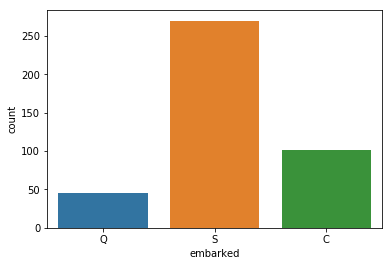

In [10]:
sns.countplot(x = 'embarked', data = test_data)
plt.show()

In [11]:
# Reemplazamos los nulos de 'Embarked' por el puerto más popular
titanic['embarked'].fillna('S', inplace = True)

In [12]:
#Nueva columna para combinar no. padres/hijos y no. hermanos/esposas
titanic['companion'] = [1 if p + s > 0 else 0 for p,s in zip(titanic['parch'], titanic['sibsp'])]
test_data['companion'] = [1 if p + s > 0 else 0 for p,s in zip(test_data['parch'], test_data['sibsp'])]

In [13]:
#Quitamos las columnas que no sirven para el análisis
titanic.drop(columns = ['cabin', 'name','ticket', 'parch', 'sibsp', 'passengerId'], inplace = True)
test_data.drop(columns = ['cabin', 'name','ticket', 'parch', 'sibsp', 'passengerId'], inplace = True)


In [14]:
titanic.head()

,survived,pclass,sex,age,fare,embarked,companion
0,0,3,male,22.0,7.2500,S,1
1,1,1,female,38.0,71.2833,C,1
2,1,3,female,26.0,7.9250,S,0
3,1,1,female,35.0,53.1000,S,1
4,0,3,male,35.0,8.0500,S,0


In [15]:
#Creamos variables dummies para variables categóricas
#Grupo control = (mujer, 1º clase, puerto Q, niño, sin acompañantes)
titanic = pd.get_dummies(titanic, columns = ['pclass', 'sex'], prefix = ['class', 'is'], drop_first = True)
titanic = pd.get_dummies(titanic, columns = ['embarked'], prefix = 'port')
titanic["is_adult"] = np.where(titanic["age"] >= 18, 1, 0)
titanic.drop(columns = ['age'], inplace = True)

test_data = pd.get_dummies(test_data, columns = ['pclass', 'sex'], prefix = ['class', 'is'], drop_first = True)
test_data = pd.get_dummies(test_data, columns = ['embarked'], prefix = ['port'])
test_data["is_adult"] = np.where(test_data["age"] >= 18, 1, 0)
test_data.drop(columns = ['age'], inplace = True)


In [66]:
titanic2 = titanic.copy()
test_2 = test_data.copy()

In [67]:
titanic = titanic2.copy()
test_data = test_2.copy()

In [38]:
titanic.drop(columns = 'port_Q', inplace = True)
test_data.drop(columns = 'port_Q', inplace = True)

In [16]:
titanic.head()

,survived,fare,companion,class_2,class_3,is_male,port_C,port_Q,port_S,is_adult
0,0,7.2500,1,0,1,1,0,0,1,1
1,1,71.2833,1,0,0,0,1,0,0,1
2,1,7.9250,0,0,1,0,0,0,1,1
3,1,53.1000,1,0,0,0,0,0,1,1
4,0,8.0500,0,0,1,1,0,0,1,1


#### Logit

In [119]:
train, test = train_test_split(titanic, test_size = 0.35, random_state = 158999)

In [189]:
sum(train["survived"])

228

In [188]:
sum(test["survived"])

114

In [162]:
y = train['survived']
X = train.drop(columns = ['survived'])

y_test = test['survived']
X_test = test.drop(columns = ['survived'])

In [163]:
logit = sm.Logit(y,X)
logit_model = logit.fit()

Optimization terminated successfully.
         Current function value: 0.463118
         Iterations 6


In [164]:
logit_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               survived   No. Observations:                  579
Model:                          Logit   Df Residuals:                      571
Method:                           MLE   Df Model:                            7
Date:                Tue, 09 Apr 2019   Pseudo R-squ.:                  0.3092
Time:                        09:40:59   Log-Likelihood:                -268.15
converged:                       True   LL-Null:                       -388.17
                                        LLR p-value:                 3.636e-48
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
fare           0.0065      0.003      1.955      0.051   -1.73e-05       0.013
companion      0.1505      0.246      0.612      0.540      -0.331       0.632
class_2        0.4184      0.323      1.296      0.195      -0.214       1.051
class_3       -0.8387      0.269     -3.113      0.002      -1.367      -0.311
is_male       -2.3749      0.237    -10.015      0.000      -2.840      -1.910
port_C         1.4966      0.407      3.677      0.000       0.699       2.294
port_S         0.7696      0.354      2.176      0.030       0.076       1.463
is_adult       0.1485      0.276      0.538      0.590      -0.392       0.690
==============================================================================
"""

In [165]:
logreg = LogisticRegression()
logreg.fit(X, y)
y_pred = logreg.predict(X_test)

In [190]:
sum(y_pred)

96

In [166]:
logreg.score(X_test, y_test)

0.7756410256410257

In [167]:
confusion_matrix(y_test, y_pred)

array([[172,  26],
       [ 44,  70]])

In [171]:
#Quitamos columnas cuyo p-value sea < 0.05

X2 = train.drop(columns = ['survived','fare','companion'])
X2_test = test.drop(columns = ['survived','fare','companion'])

In [172]:
logit_v2 = sm.Logit(y,X2)
logit_model_v2 = logit_v2.fit()

Optimization terminated successfully.
         Current function value: 0.469420
         Iterations 6


In [173]:
logit_model_v2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               survived   No. Observations:                  579
Model:                          Logit   Df Residuals:                      573
Method:                           MLE   Df Model:                            5
Date:                Tue, 09 Apr 2019   Pseudo R-squ.:                  0.2998
Time:                        09:51:21   Log-Likelihood:                -271.79
converged:                       True   LL-Null:                       -388.17
                                        LLR p-value:                 2.757e-48
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
class_2        0.1736      0.296      0.586      0.558      -0.407       0.754
class_3       -1.1027      0.236     -4.677      0.000      -1.565      -0.641
is_male       -2.4782      0.229    -10.800      0.000      -2.928      -2.028
port_C         2.0388      0.351      5.811      0.000       1.351       2.726
port_S         1.1886      0.311      3.826      0.000       0.580       1.797
is_adult       0.2493      0.273      0.915      0.360      -0.285       0.784
==============================================================================
"""

In [177]:
logreg_v2 = LogisticRegression()
logreg_v2.fit(X2, y)
y2_pred = logreg_v2.predict(X2_test)

In [180]:
logreg_v2.score(X2_test, y_test)

0.7756410256410257

In [181]:
confusion_matrix(y_test, y2_pred)

array([[167,  31],
       [ 39,  75]])

In [155]:
# Un modelo con solo is male, is adult y class
X3 = train.drop(columns = ['survived', 'companion', 'port_C', 'port_S','fare'])
X3_test = test.drop(columns = ['survived', 'companion', 'port_C', 'port_S','fare'])
logit_v3 = sm.Logit(y,X3)
logit_model_v3 = logit_v3.fit()
logit_model_v3.summary()

Optimization terminated successfully.
         Current function value: 0.502174
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               survived   No. Observations:                  579
Model:                          Logit   Df Residuals:                      575
Method:                           MLE   Df Model:                            3
Date:                Tue, 09 Apr 2019   Pseudo R-squ.:                  0.2509
Time:                        09:40:08   Log-Likelihood:                -290.76
converged:                       True   LL-Null:                       -388.17
                                        LLR p-value:                 5.557e-42
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
class_2        0.4666      0.257      1.815      0.070      -0.037       0.971
class_3       -0.8734      0.213     -4.092      0.000      -1.292      -0.455
is_male       -2.1787      0.212    -10.280      0.000      -2.594      -1.763
is_adult       1.1498      0.210      5.480      0.000       0.739       1.561
==============================================================================
"""

In [192]:
sum(y3_pred)

108

In [133]:
logreg_v3 = LogisticRegression()
logreg_v3.fit(X3, y)
y3_pred = logreg_v3.predict(X3_test)

In [134]:
logreg_v3.score(X3_test, y_test)

0.782051282051282

In [135]:
confusion_matrix(y_test, y3_pred)

array([[167,  31],
       [ 37,  77]])

In [136]:
X3.head()

,class_2,class_3,is_male,is_adult
71,0,1,0,0
845,0,1,1,1
716,0,0,0,1
691,0,1,0,0
613,0,1,1,1


In [137]:
logreg_v3.coef_

array([[-0.41405296, -1.82165053, -2.48079268, -0.6495365 ]])

In [138]:
logreg_v3.intercept_

array([2.63749586])

In [139]:
logreg_v3.decision_function([[0,0,0,0]])

array([2.63749586])

In [140]:
# Grupos de valores de varibles
grupos = [[0,0,0,0], [1,0,0,0], [0,1,0,0],
          [0,0,0,1], [1,0,0,1], [0,1,0,1],
          [0,0,1,0], [1,0,1,0], [0,1,1,0],
          [0,0,1,1], [1,0,1,1], [0,1,1,1]]

# Probabilidad de los grupos en logit 3
probs = np.exp(logreg_v3.decision_function(grupos))/(1+np.exp(logreg_v3.decision_function(grupos)))
probs

array([0.93323611, 0.90233503, 0.69335371, 0.87952708, 0.82833979,
       0.54148164, 0.53909583, 0.4360153 , 0.15909899, 0.37922634,
       0.28763742, 0.0899305 ])

|Sexo|Adulto|Clase 1|Clase 2|Clase 3|
|----|----|----:|----:|----:|
|Mujer|Niño|0.9181588|0.8816249|0.6477092|
|Mujer|Adulto|0.8809890|0.8309181|0.5481563|
|Hombre|Niño|0.4824000|0.3822259|0.1324997|
|Hombre|Adulto|0.3807915|0.2898996|0.0915549|

In [141]:
len(df)

891

In [142]:
sum(df["survived"])

342

In [94]:
df.head()

,passengerId,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
